In [1]:
from astropy.io import fits

import matplotlib.pyplot as plt

import numpy as np
import time
import itertools
import scipy.stats as stats

from ProbabilisticDiffusion import Diffusion
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import sys

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 256, n_steps)
        self.lin2 = ConditionalLinear(256, 512, n_steps)
        self.lin3 = ConditionalLinear(512, 256, n_steps)
        self.lin4 = nn.Linear(256, 2)
    
    def forward(self, x, y):
        x = torch.tanh(self.lin1(x, y))
        x = torch.tanh(self.lin2(x, y))
        x = torch.tanh(self.lin3(x,y))
        return self.lin4(x)


In [2]:
apogee14 = fits.open('apogee-rc-DR14.fits')
apogee14.info()
#To find relevant data indices for si_fe and mg_fe
#apogee14[1].header

Filename: apogee-rc-DR14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    385   29502R x 187C   [45A, 46A, 18A, 8A, I, 16A, E, E, E, E, E, E, D, D, D, D, J, J, J, 140A, 14A, 3J, J, J, I, E, J, 165A, J, 74A, E, E, E, E, E, E, E, E, J, J, J, E, E, E, I, E, E, E, E, 9E, 9E, 81E, 81E, E, E, E, E, E, E, E, E, E, E, E, E, 5A, J, 183A, 9J, 26E, 26E, 26E, 26E, 26E, 26E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, J, 26E, 26J, E, 17A, 845A, 804A, 50J, 50J, 207E, 23E, D, D, D, D, D, J, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D, D, J, D, D, D]   


In [3]:
data = apogee14[1].data
mg_fe = [x[80] for x in data]
si_fe = [x[82] for x in data]
# Removes -9999.0
flag = True
while flag:
    try:
        idx = si_fe.index(-9999.0)
        del si_fe[idx]
        del mg_fe[idx]
    except ValueError:
        print('Done')
        flag = False
data = torch.stack([torch.tensor(si_fe, dtype=torch.float), torch.tensor(mg_fe, dtype=torch.float)],dim=1)
# Normalizing
data[:, 0] = data[:, 0]/ max(data[:,0])
data[:, 1] = data[:, 1]/ max(data[:,1])

Done


Upper Blob Portion:
2422


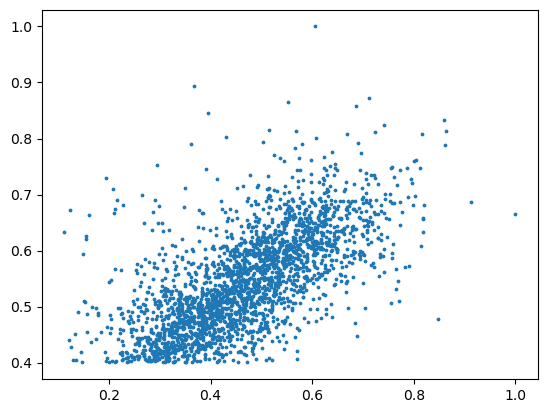

In [4]:
check = [True if i[0] > 0.1 and i[1] > 0.4 else False for i in data]
checked = data[check]
print('Upper Blob Portion:')
print(len(checked))
plt.scatter(checked[:,0], checked[:,1], s=3)
plt.show()

Lower Blob Portion:
27078


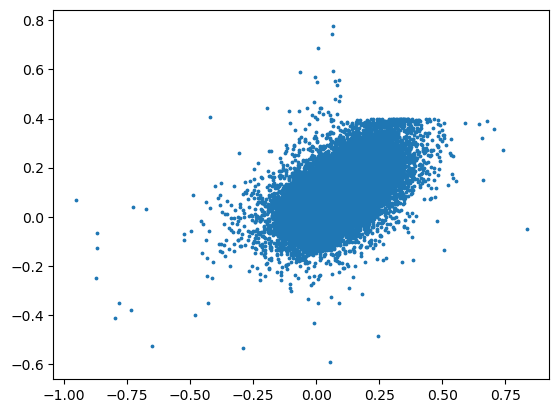

In [5]:
checked = data[~np.array(check)]
print('Lower Blob Portion:')
print(len(checked))
plt.scatter(checked[:,0], checked[:,1], s=3)
plt.show()

In [6]:
n_steps=100
model = ConditionalModel(n_steps)
loss = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
diffusion = Diffusion(data, n_steps,
                 1e-6, 1e-2, 'linear',
                 model, loss, optimizer)

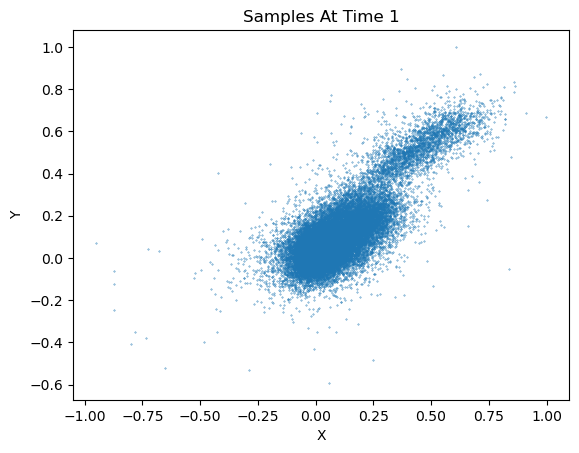

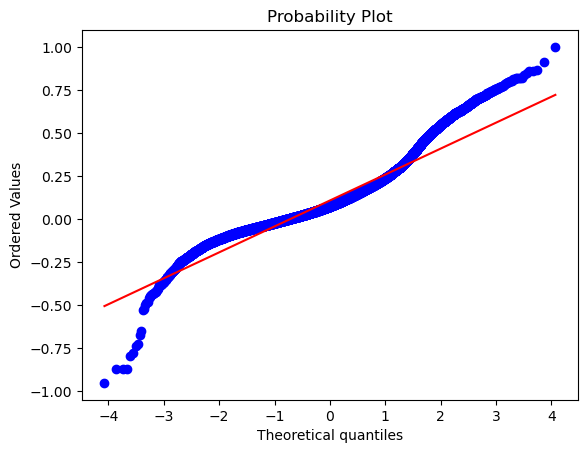

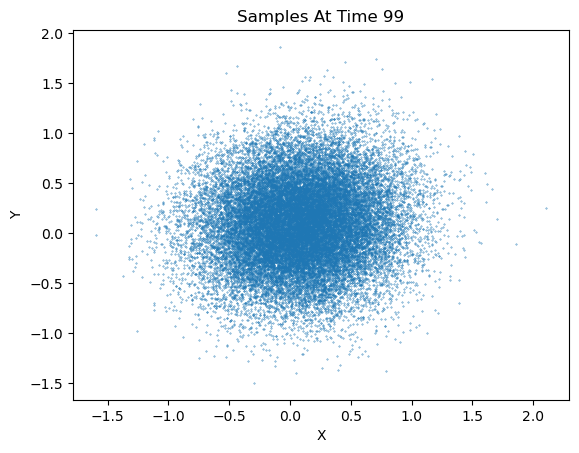

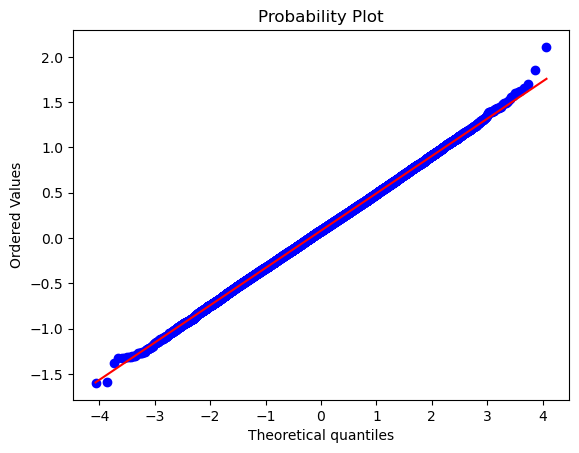

In [7]:
noised = diffusion.forward(1, s=0.1)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()
noised = diffusion.forward(99, s=0.1)
plt.show()
stats.probplot(noised[:,0], dist="norm", plot=plt)
plt.show()

100%|███████████████████████████| 1000/1000 [35:55<00:00,  2.16s/it, loss=0.205]


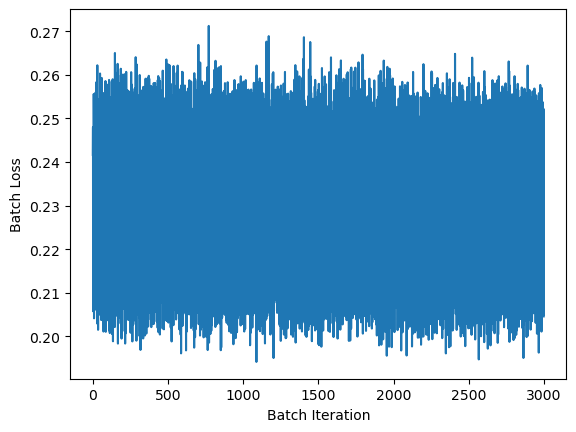

In [11]:
diffusion.train(10000, 1000)

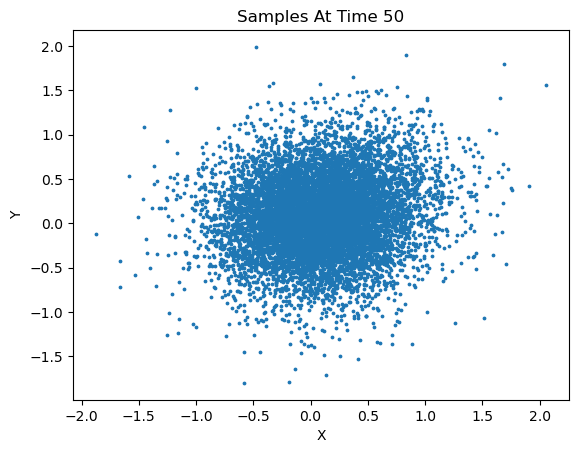

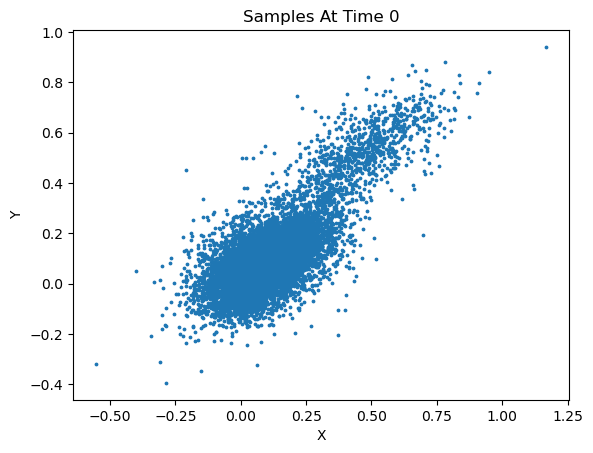

In [12]:
new_x = diffusion.sample(10000, 50, s=3)

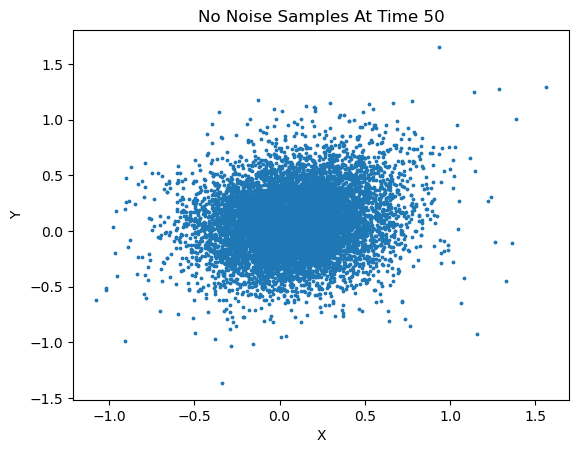

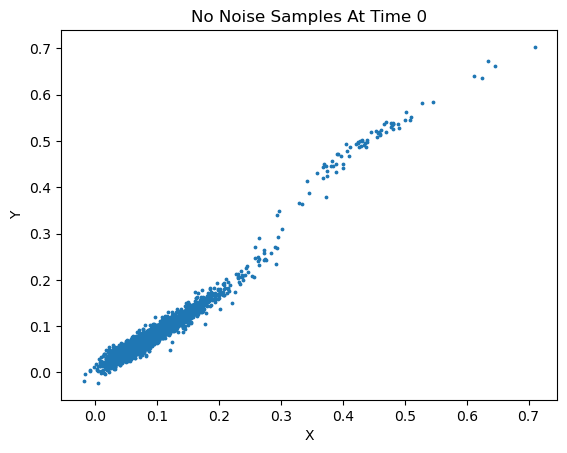

In [14]:
new_x = diffusion.sample(10000, 50, no_noise=True, s=3)